# Polynomial regression approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import rasterio
from rasterio import mask

In [2]:
import rasterio
print(rasterio.__version__)


1.4.3


In [3]:
# Step 1: Load raster data and preprocess
# Read the hyperspectral image (assuming you have a raster file)
pca_hs_image_path = 'C:/Users/Patrick/Documents/GitHub/UWW200_Master_Thesis_public/SpectralPatang/test_cropped_flightstrip/ang20190712t231624rfl/result/ang20190712t231624_rfl_v2v2_img_rectified_cut/SPCA/PCA/OutputPCA_30_PCs'


In [5]:
with rasterio.open(pca_hs_image_path) as src:
    pca_hs_image = src.read([1, 2, 3, 4, 5 , 6, 7, 8 ,9 ,10 ,11, 12 ,13 ,14 ,15 ,16 , 17])  # Read the first 4 PCA bands
    #pca_hs_image_subset = src.sel(band=slice(1, 17))
    profile = src.profile

In [6]:
type(pca_hs_image)

numpy.ndarray

In [7]:
pca_hs_image

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [8]:
pca_hs_image.shape

(17, 106, 107)

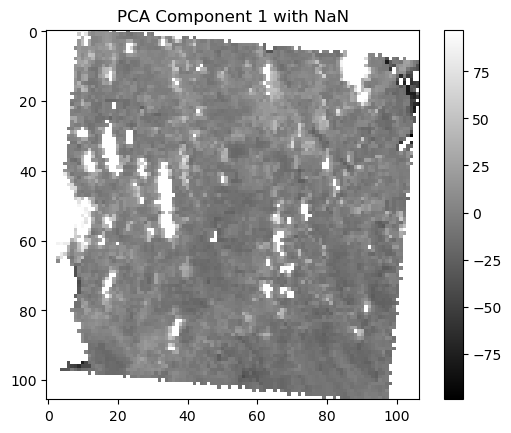

In [9]:
# Plot PCA Component 1, ignoring NaN
plt.imshow(pca_hs_image[0], cmap='gray', interpolation='none')
plt.colorbar()
plt.title("PCA Component 1 with NaN")
plt.show()

In [10]:
# Mask rows and columns with NaNs
valid_rows = ~np.isnan(pca_hs_image).all(axis=(0, 2))  # Keep rows without all NaNs
valid_cols = ~np.isnan(pca_hs_image).all(axis=(0, 1))  # Keep cols without all NaNs

# Apply mask
cleaned_pca_image = pca_hs_image[:, valid_rows, :][:, :, valid_cols]


In [11]:
cleaned_pca_image.shape

(17, 106, 104)

In [12]:
# Compute statistics, ignoring NaN
means = [np.nanmean(cleaned_pca_image[i]) for i in range(4)]
variances = [np.nanvar(cleaned_pca_image[i]) for i in range(4)]

print("Means:", means)
print("Variances:", variances)


Means: [np.float32(0.0), np.float32(-5.4507844e-08), np.float32(5.4507844e-08), np.float32(0.0)]
Variances: [np.float32(248.17828), np.float32(98.57772), np.float32(15.481137), np.float32(3.5349069)]


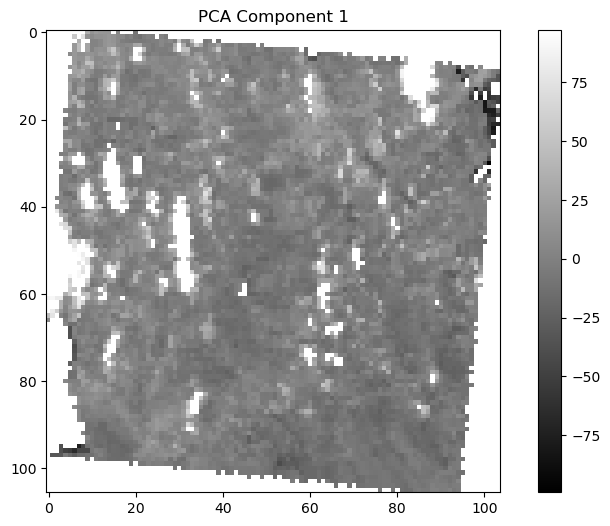

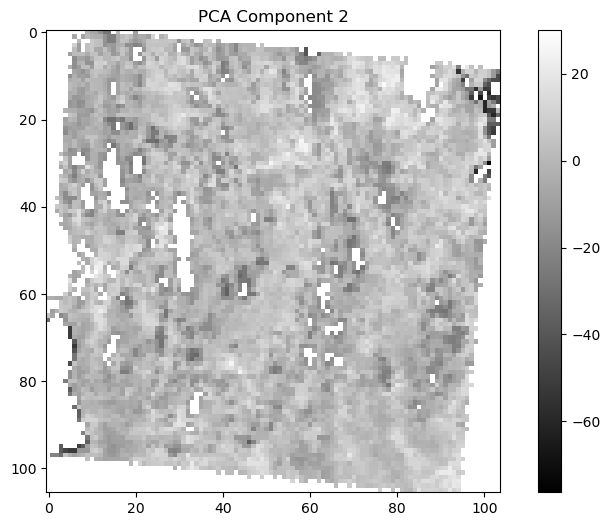

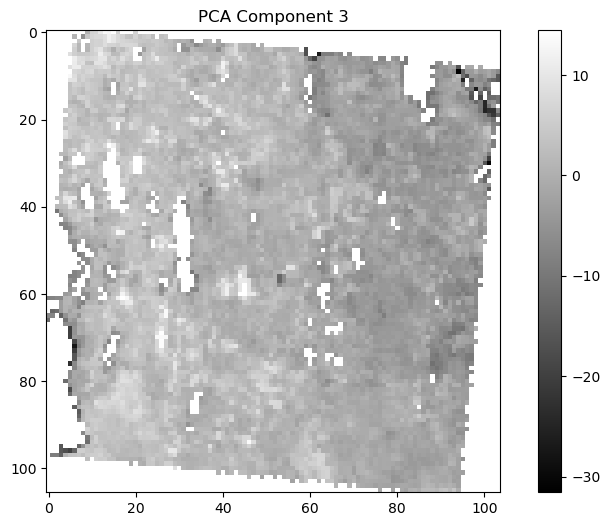

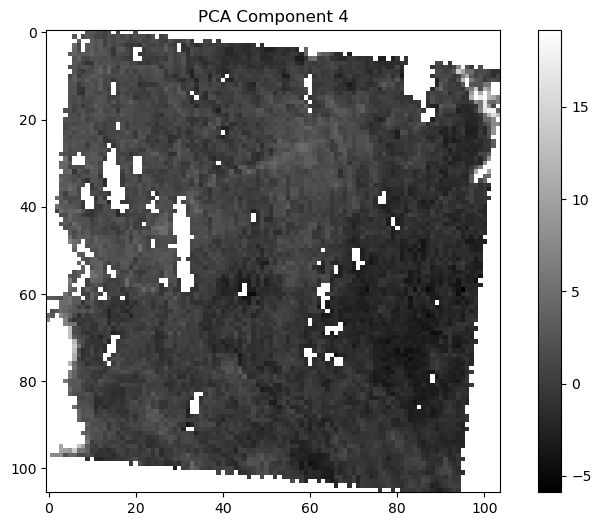

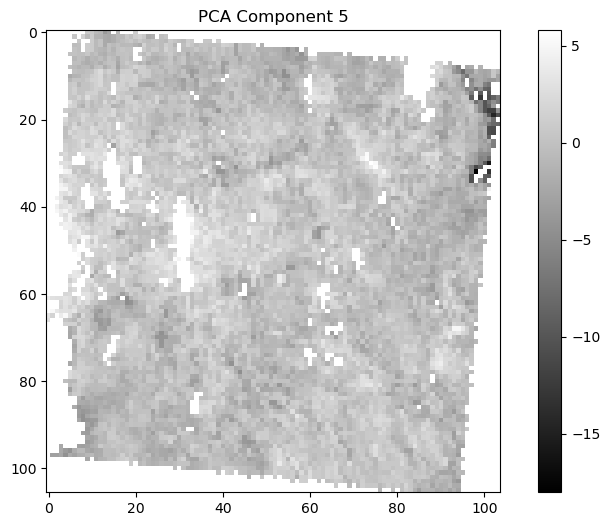

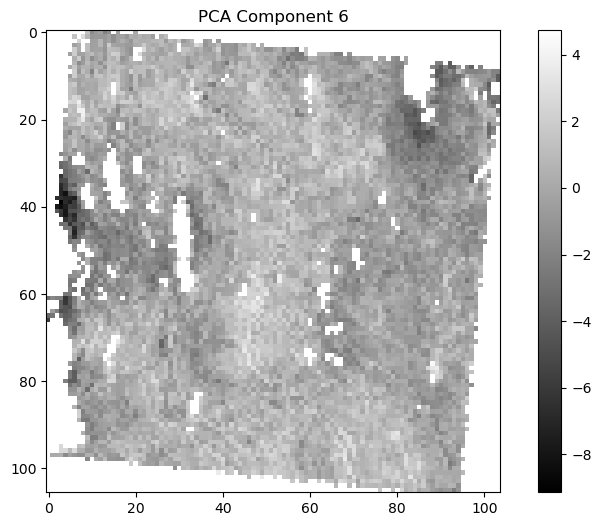

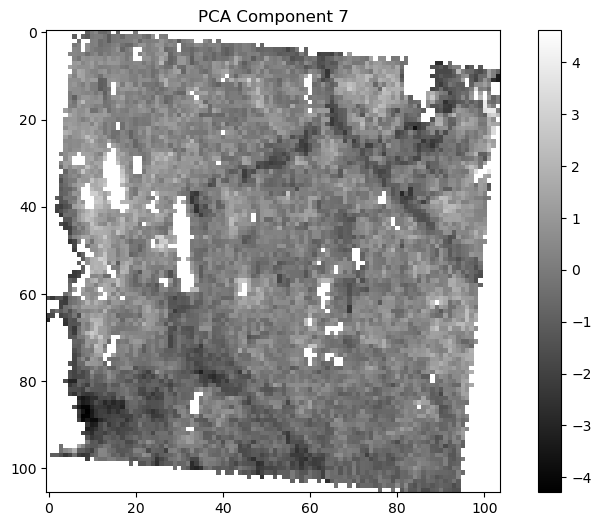

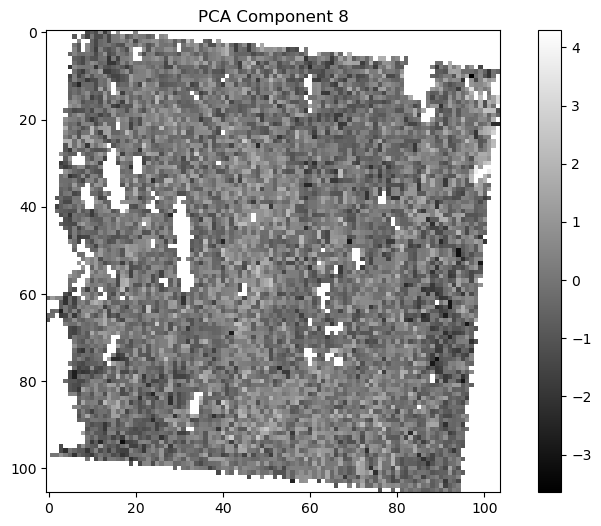

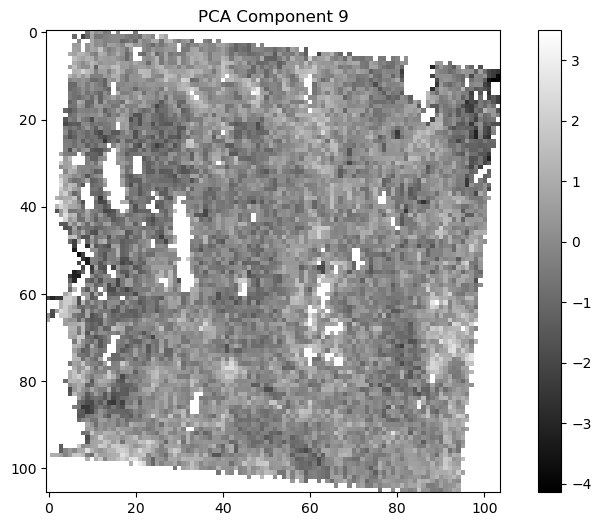

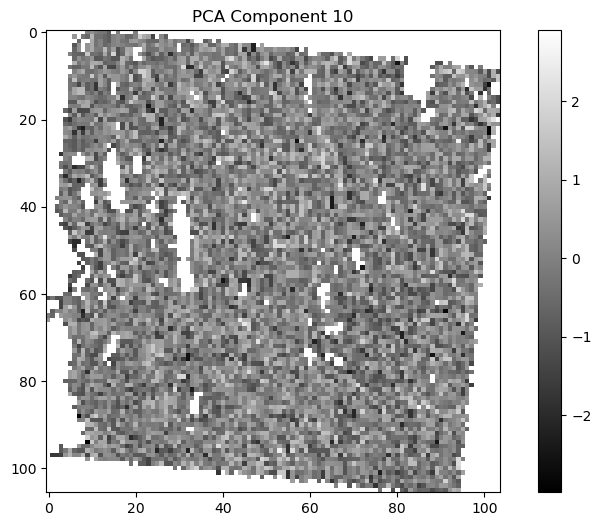

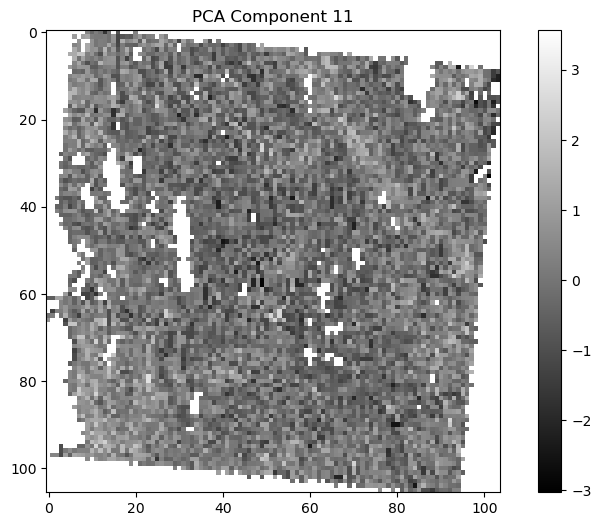

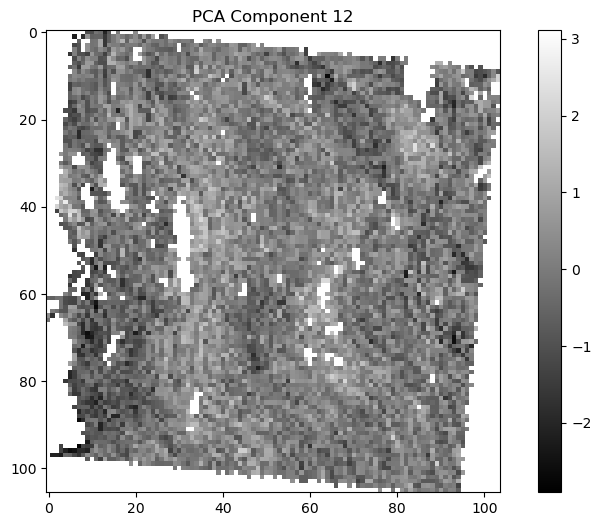

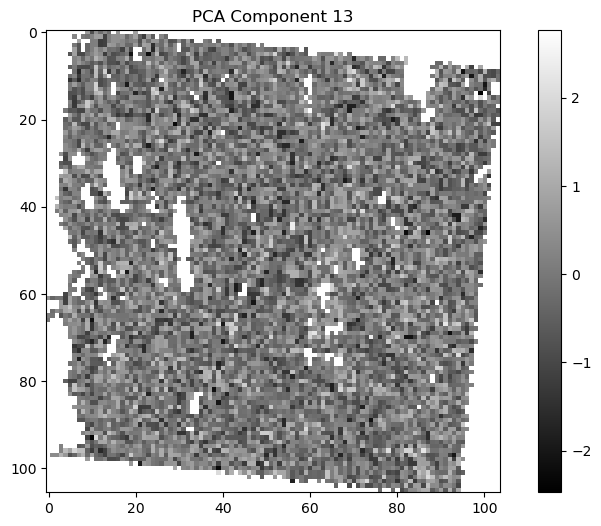

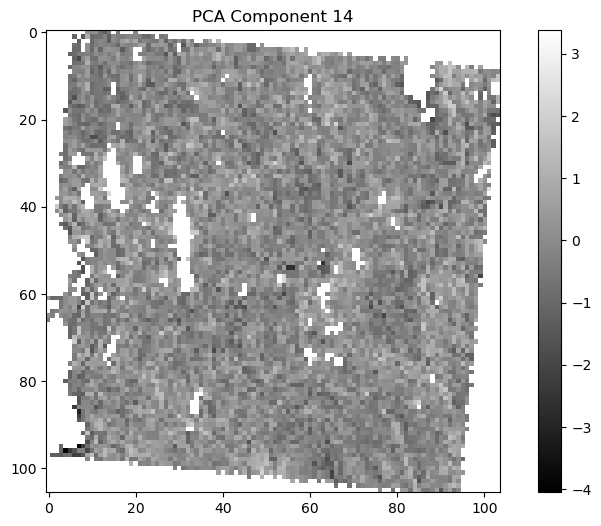

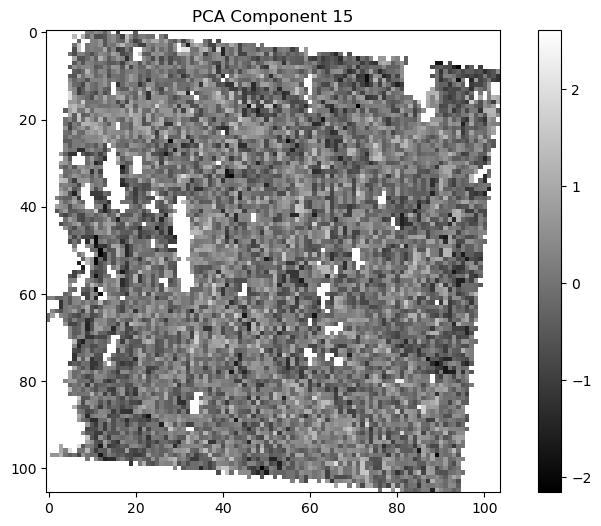

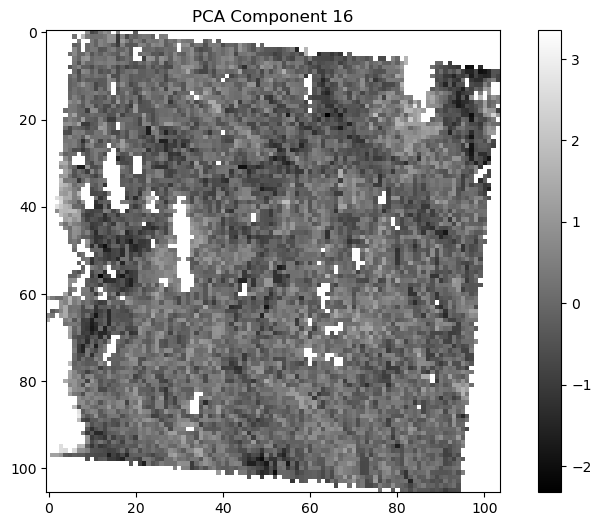

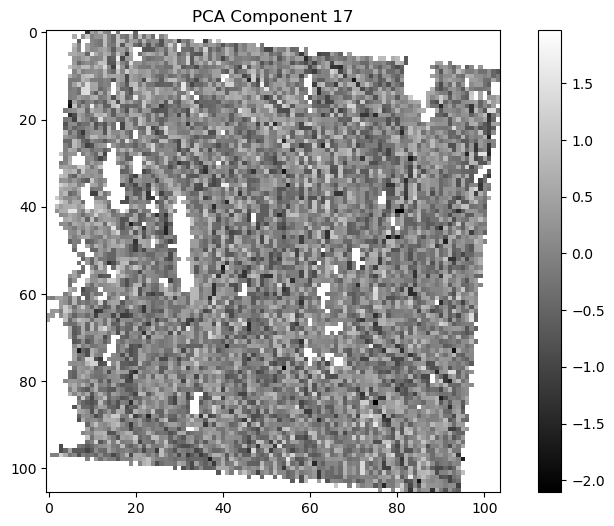

In [14]:
import matplotlib.pyplot as plt

# Iterate over the 4 PCA components and plot them
for i in range(17):
    plt.figure(figsize=(10, 6))
    plt.imshow(cleaned_pca_image[i], cmap='gray', interpolation='none')
    plt.title(f'PCA Component {i+1}')
    plt.colorbar()
    plt.show()


In [16]:
np.count_nonzero(np.isnan(cleaned_pca_image))

35122

In [17]:
np.count_nonzero(~np.isnan(cleaned_pca_image))

152286

In [18]:
d = pca_hs_image[np.logical_not(np.isnan(pca_hs_image))]

In [19]:
np.count_nonzero(~np.isnan(d))

152286

In [20]:
d.shape

(152286,)

In [ ]:
# Step 2: Downsample the raster (reduce spatial resolution)
# Here we use average pooling to downsample (equivalent to 'terra::aggregate')
def downsample_raster(raster_data, factor=5):
    new_shape = (raster_data.shape[1] // factor, raster_data.shape[2] // factor)
    return np.mean(raster_data[:, ::factor, ::factor], axis=(1, 2))

# Downsample the PCA data
pca_data_downsampled = downsample_raster(pca_hs_image)

In [ ]:
# Step 3: Reshape and preprocess the data
# Flatten the PCA data into a 2D array (each pixel is a row)
pca_data_reshaped = pca_hs_image.reshape((-1, pca_hs_image.shape[0])).T  # (n_samples, n_features)


In [ ]:
pca_data_reshaped = pca_data_reshaped[~np.isnan(pca_data_reshaped).any(axis=1)]  # Remove rows with NaN


In [ ]:
# Step 4: Calculate WSS for different k values
wss = []
k_range = range(2, 16)  # From 2 to 15 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pca_data_reshaped)
    wss.append(kmeans.inertia_)  # WSS is the inertia attribute of kmeans

In [ ]:
# Step 5: Use Kneedle to find the "elbow"
kneedle = KneeLocator(k_range, wss, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow

In [ ]:
# Step 6: Plot the WSS and highlight the optimal k
plt.figure(figsize=(8, 6))
plt.plot(k_range, wss, marker='o', label="WSS (within-cluster sum of squares)")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.legend()
plt.show()

In [ ]:
# Step 7: Print the optimal number of clusters
print(f"Optimal number of clusters (k) determined by Kneedle: {optimal_k}")